In [1]:
import random

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.mask import *
from pycocotools.coco import COCO

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()

In [3]:
transform = transforms.Compose([
#     transforms.Scale([448, 448]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1
dset = datasets.CocoDetection('data/coco-detection/train2017/', 
                              'data/coco-detection/annotations/instances_train2017.json',
                              transform=transform)
# dataloader = torch.utils.data.DataLoader(dset, shuffle=True, batch_size=batch_size)

loading annotations into memory...
Done (t=17.85s)
creating index...
index created!


In [4]:
def imshow(input, ax, title=None):
    input = input.numpy().transpose(1, 2, 0)
    std = [0.229, 0.224, 0.225]
    mean = [0.485, 0.456, 0.406]
    input = std * input + mean
    ax.imshow(input)
    if title is not None:
        ax.set_title(title)

tv
chair
cup
laptop
mouse
keyboard
scissors
mouse


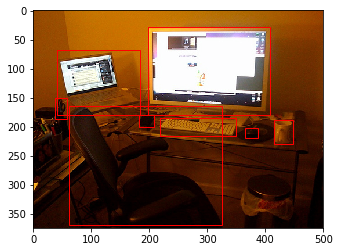

In [5]:
i = random.choice(range(len(dset)))
input, label = dset[i]

fig, ax = plt.subplots()
imshow(input, ax)
for obj in label:
    print(dset.coco.loadCats(obj['category_id'])[0]['name'])
    b = obj['bbox']
    rect = patches.Rectangle(b[:2], b[2], b[3], linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [13]:
class FCN(nn.Module):
    def __init__(self, n_classes):
        super(FCN, self).__init__()
        
        self.n_classes = n_classes
        
        # VGG16 network architecture
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(size=2, stride=2, dilation=1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(size=2, stride=2, dilation=1)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(size=2, stride=2, dilation=1)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(size=2, stride=2, dilation=1)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(size=2, stride=2, dilation=1)
    
        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout2d()
        
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout2d()
        
        self.score_fr = nn.Conv2d(4096, n_classes, 1)
        self.upscore2 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=2, bias=False)
        
        self.score_pool4 = nn.Conv2d(512, n_classes, kernel_size=1)
        self.score_pool3 = nn.Conv2d(256, n_classes, kernel_size=1)
        
        self.upscore_pool4 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=16, stride=4, bias=False)
        
    def forward(self, input):
        input = self.relu1_1(self.conv1_1(input))
        input = self.relu1_2(self.conv1_2(input))
        input = self.pool1(input)
        
        input = self.relu2_1(self.conv2_1(input))
        input = self.relu2_2(self.conv2_2(input))
        input = self.pool2(input)
        
        input = self.relu3_1(self.conv3_1(input))
        input = self.relu3_2(self.conv3_2(input))
        input = self.relu3_3(self.conv3_3(input))
        input = self.pool3(input)
        pool3 = input
        
        input = self.relu4_1(self.conv4_1(input))
        input = self.relu4_2(self.conv4_2(input))
        input = self.relu4_3(self.conv4_3(input))
        input = self.pool4(input)
        pool4 = input
        
        input = self.relu5_1(self.conv5_1(input))
        input = self.relu5_2(self.conv5_2(input))
        input = self.relu5_3(self.conv5_3(input))
        input = self.pool5(input)
        
        input = self.relu6(self.conv6(input))
        input = self.dropout6(input)
        
        input = self.relu7(self.conv7(input))
        input = self.dropout7(input)
        
        score_fr = self.score_fr(input)
        upscore2 = self.upscore2(score_fr)
        
        print(upscore2.size())
        
        score_pool4 = self.score_pool4(pool4)
        print(score_pool4.size())
        #score_pool4c
        fuse_pool4 = score_pool4 + upscore2
        upscore_pool4 = self.upscore_pool4(fuse_pool4)
        
        score_pool3 = self.score_pool3(pool3)
        #score_pool3c
        fuse_pool3 = score_pool3 + upscore_pool4
        upscore8 = self.upscore8(fuse_pool3)
        
        return upscore8